In [2]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [29]:
robot.getStates()

{'q': array([ 7.24198320e-04, -7.84328851e-01,  1.61750824e-03, -2.36790243e+00,
        -9.43747411e-04,  1.57099819e+00,  7.86100601e-01]),
 'dq': array([ 1.64349739e-04, -6.23138979e-04, -9.74567734e-04, -9.63199856e-05,
        -4.07372888e-04, -4.39588722e-05,  8.34694149e-04]),
 'T': array([-0.15939641, -4.22265768, -0.82716978, 23.17111588,  1.04295576,
         2.14139533, -0.0571954 ])}

In [30]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
n_joints = 7
q_bar = 0.5*(joint_ub + joint_lb)
P_EE_desired = np.array([0.42, 0.50, 0.0])
R_EE_desired = np.array([[1, 0, 0],
                        [0, -1, 0],
                        [0, 0, -1]])
P_EE_initial = np.array([0.30, 0.0, 0.47])

### Inverse dynamic control (initial pose to pre-cleaning pose)

In [31]:
from cores.utils.trajectory_utils import TrapezoidalTrajectory

via_points = np.array([P_EE_initial, P_EE_desired])
target_time = np.array([0, 10])
traj = TrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

In [32]:
from cores.utils.control_utils import get_torque_to_track_traj_const_ori

T = 12

Kp_task = np.diag([40,40,40,100,100,100])
Kd_task = np.diag([40,40,40,100,100,100])

Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*10
Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*10

delta = 0.1

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    S, u_task = get_torque_to_track_traj_const_ori(traj_pos, traj_vel, traj_acc, R_EE_desired, Kp_task, Kd_task, Minv, J_EE, dJdq_EE, dq, P_EE, R_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_bar)
    deq = W @ dq
    u_joint = M @ (- Kd_joint @ deq - Kp_joint @ eq) 

    # Compute the input torque
    Spinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    u_nominal =  Spinv @ u_task + (np.eye(len(q)) - Spinv @ S) @ u_joint
    u = np.clip(u_nominal, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))


### Press against the surface while tracking a circular trajectory with friction compensation

In [33]:
from cores.utils.trajectory_utils import CircularTrajectory
duration = 100
start_time = 0
end_time = start_time + duration
dist_to_surface = -0.01
P_start_point = np.array([0.42, 0.50, dist_to_surface])
P_center = np.array([0.32, 0.50, dist_to_surface])
nominal_linear_vel = 0.05
R_b_to_w = np.eye(3)
traj = CircularTrajectory(P_center, P_start_point, nominal_linear_vel, R_b_to_w, start_time, end_time)


In [34]:
from cores.utils.proxsuite_utils import init_proxsuite_qp
import diffOptHelper as doh
from cores.utils.control_utils import get_domega_to_track_const_ori

# Load the obstacle
obs_pos_2d = np.array([0.1, 0.45])
obs_size_2d = np.array([0.05, 0.1])
obs_orientation_2d = np.deg2rad(0)
obs_R_2d = np.array([[np.cos(obs_orientation_2d), -np.sin(obs_orientation_2d)],
                    [np.sin(obs_orientation_2d), np.cos(obs_orientation_2d)]]) 
obs_coef_2d = obs_R_2d @ np.diag(1/obs_size_2d**2) @ obs_R_2d.T

# Load the bounding shape 
eraser_bb_size_2d = np.array([0.088, 0.035])
eraser_D_2d = np.diag(1/eraser_bb_size_2d**2)

# Initiate QP
n_CBF = 1
cbf_qp = init_proxsuite_qp(n_v=2, n_eq=0, n_in=n_CBF)

# CBF parameters
alpha0 = [1.3]
gamma1 = [10.0]
gamma2 = [10.0]
compensation = [0]

In [35]:
T = 30

Kp_task = np.diag([40,40,40,200,200,200])
Kd_task = np.diag([30,30,30,100,100,100])
Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*200
Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*160
F_press = np.array([0, 0, -10, 0, 0, 0])
mu_friction = 0.305
delta = 0.1

# Records
states_2d_list = []
u_nominal_list = []
t_list = []

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    tau_m = robot_info["T"] # shape (6,)
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)
    tau_ext = tau_m - nle

    # Primary objective: 2D tracking while avoiding collision
    theta_2d = np.arctan2(R_EE[1,0], R_EE[0,0])
    states = np.array([P_EE[0], P_EE[1], theta_2d])
    states_dt = np.array([v_EE[0], v_EE[1], v_EE[5]])

    states = np.array([P_EE[0], P_EE[1], theta_2d])
    states_dt = np.array([v_EE[0], v_EE[1], v_EE[5]])
    traj_2d = np.array([traj_pos[0], traj_pos[1]])
    traj_2d_dt = np.array([traj_vel[0], traj_vel[1]])
    traj_2d_dtdt = np.array([traj_acc[0], traj_acc[1]])
    Kp_2d = np.diag([40,40])
    Kd_2d = np.diag([30,30])
    u_2d_nominal = traj_2d_dtdt - Kp_2d @ (states[0:2]-traj_2d) - Kd_2d @ (states_dt[0:2]-traj_2d_dt) # shape (2,)

    C = np.zeros([n_CBF, 2])
    lb = np.zeros(n_CBF)
    ub = np.zeros(n_CBF)
    CBF_tmp = np.zeros(n_CBF)
    phi1_tmp = np.zeros(n_CBF)
    phi2_tmp = np.zeros(n_CBF)

    for kk in range(n_CBF):
        eraser_pos_2d = states[0:2]
        eraser_theta = states[2]
        eraser_R_2d = np.array([[np.cos(eraser_theta), -np.sin(eraser_theta)],
                                [np.sin(eraser_theta), np.cos(eraser_theta)]])
        alpha, _, alpha_dx_tmp, alpha_dxdx_tmp = doh.getGradientAndHessianEllipses(eraser_pos_2d, eraser_theta, eraser_D_2d,
                                                                                eraser_R_2d, obs_coef_2d, obs_pos_2d)

        # Order of parameters in alpha_dx_tmp and alpha_dxdx_tmp: [theta, x, y]
        # Convert to the order of [x, y, theta]
        alpha_dx = np.zeros(3)
        alpha_dx[0:2] = alpha_dx_tmp[1:3]
        alpha_dx[2] = alpha_dx_tmp[0]

        alpha_dxdx = np.zeros((3, 3))
        alpha_dxdx[0:2,0:2] = alpha_dxdx_tmp[1:3,1:3]
        alpha_dxdx[2,2] = alpha_dxdx_tmp[0,0]
        alpha_dxdx[0:2,2] = alpha_dxdx_tmp[0,1:3]
        alpha_dxdx[2,0:2] = alpha_dxdx_tmp[1:3,0]

        # CBF-QP constraints
        dCBF =  alpha_dx @ states_dt # scalar
        CBF = alpha - alpha0[kk]
        phi1 = dCBF + gamma1[kk] * CBF

        C[kk,:] = alpha_dx[0:2]
        lb[kk] = - gamma2[kk]*phi1 - gamma1[kk]*dCBF - states_dt.T @ alpha_dxdx @ states_dt + compensation[kk]
        ub[kk] = np.inf

        CBF_tmp[kk] = CBF
        phi1_tmp[kk] = phi1

    # CBF-QP constraints
    g = -u_2d_nominal
    cbf_qp.update(g=g, C=C, l=lb, u=ub)
    time_cbf_qp_start = time.time()
    cbf_qp.solve()
    time_cbf_qp_end = time.time()
    u_2d = cbf_qp.results.x
    for kk in range(n_CBF):
        phi2_tmp[kk] = C[kk,:] @ u_2d - lb[kk]
    
    dv = np.zeros(6)
    dv[0:2] = u_2d

    # Secondary Objective: track the trajectory in z direction and keep the orientation constant
    Kp_z = 40
    Kd_z = 30
    dv[2] = traj_acc[2] - Kp_z * (P_EE[2] - traj_pos[2]) - Kd_z * (v_EE[2] - traj_vel[2])

    Kp_ori = np.diag([200,200,200])
    Kd_ori = np.diag([50,50,50])
    R_d = np.array([[1, 0, 0],
                    [0, -1, 0],
                    [0, 0, -1]])
    dv[3:6] = get_domega_to_track_const_ori(R_d, Kp_ori, Kd_ori, v_EE[3:6], R_EE)
    S = J_EE @ Minv
    
    # Teriary Objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_bar)
    deq = W @ dq
    Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*20
    Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*1
    u_joint = M @ (- Kd_joint @ deq - Kp_joint @ eq)

    # Other 1: apply a force on the z axis to press the end-effector against the table
    F_press = np.array([0, 0, -10, 0, 0, 0])
    u_press = J_EE.T @ F_press

    # Other 2: apply a force to compensate for the friction
    mu_friction = 0.3
    F_ext = np.linalg.pinv(J_EE.T) @ tau_ext
    z_force = F_ext[2]
    F_friction = np.zeros(6)
    if z_force < 0 and np.linalg.norm(v_EE[0:2]) > 0.01:
        friction = mu_friction * np.abs(z_force)
        direction = v_EE[0:2]/np.linalg.norm(v_EE[0:2])
        F_friction[0:2] = direction * friction
    if z_force < 0 and abs(v_EE[5]) > 0.01:
        F_friction[5] = np.sign(v_EE[5]) * mu_friction * abs(z_force) * 0.03534
    u_friction = J_EE.T @ F_friction

    # Compute the input torque
    S_pinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    S_null = np.eye(n_joints) - S_pinv @ S

    u = u_press + u_friction
    u += S_pinv @ (dv - dJdq_EE) 
    u += S_null @ u_joint

    u = np.clip(u, -10, 10)
    robot.setCommands(u)

    t_list.append(t)
    states_2d_list.append(states)
    u_nominal_list.append(u_nominal)

robot.setCommands(np.zeros_like(u))


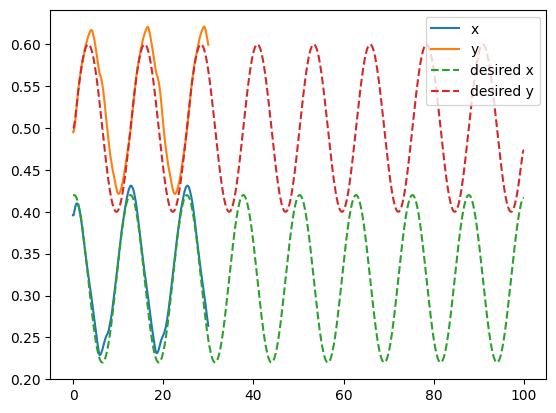

In [36]:
import matplotlib.pyplot as plt

states_2d_list = np.array(states_2d_list)
u_nominal_list = np.array(u_nominal_list)
t_list = np.array(t_list)

plt.figure()
plt.plot(t_list, states_2d_list[:,0], label='x')
plt.plot(t_list, states_2d_list[:,1], label='y')
plt.plot(traj.t, traj.pd[:,0], '--', label='desired x')
plt.plot(traj.t, traj.pd[:,1], '--', label='desired y')
plt.legend()



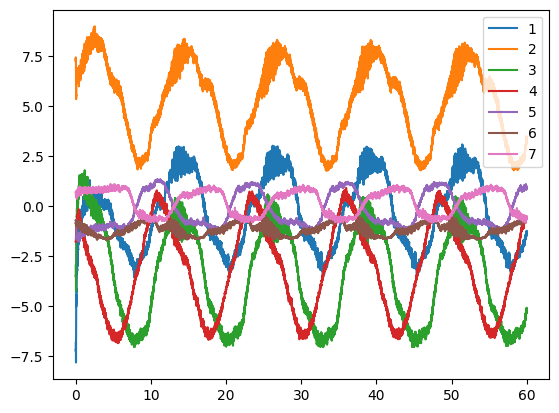

In [10]:

plt.figure()
plt.plot(t_list, u_nominal_list[:,0], label='1')
plt.plot(t_list, u_nominal_list[:,1], label='2')
plt.plot(t_list, u_nominal_list[:,2], label='3')
plt.plot(t_list, u_nominal_list[:,3], label='4')
plt.plot(t_list, u_nominal_list[:,4], label='5')
plt.plot(t_list, u_nominal_list[:,5], label='6')
plt.plot(t_list, u_nominal_list[:,6], label='7')

plt.legend()


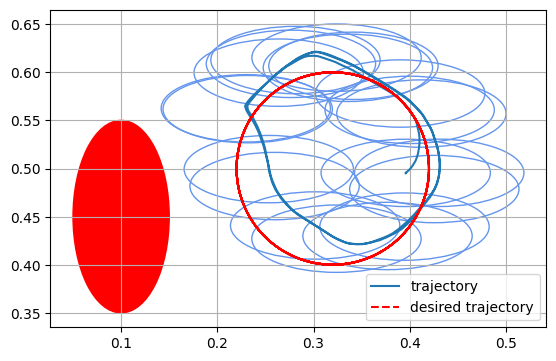

In [47]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots()
ellipse = Ellipse(xy=(obs_pos_2d[0], obs_pos_2d[1]), width=2*obs_size_2d[0], height=2*obs_size_2d[1], color='r') 
ax.plot(states_2d_list[:,0], states_2d_list[:,1], label='trajectory')
ax.plot(traj.pd[:,0], traj.pd[:,1], color='r', linestyle='--', label='desired trajectory')
ax.add_patch(ellipse)

N_recs = 20
sampled = np.linspace(0, len(states_2d_list)-1, N_recs).astype(int)
for i in range(N_recs):
    x = states_2d_list[sampled[i],0]
    y = states_2d_list[sampled[i],1]
    ellipse = Ellipse(xy=(x,y), width=2*eraser_bb_size_2d[0], height=2*eraser_bb_size_2d[1], edgecolor='cornflowerblue', facecolor='none')
    ax.add_patch(ellipse)

ax.grid()
ax.set_aspect('equal')
ax.legend()

### Recover to initial pose

In [27]:
via_points = np.array([P_EE, np.array([P_EE[0], P_EE[1], P_EE[2]+0.2])])
target_time = np.array([0, 5])
traj = TrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

In [28]:
T = 7

Kp_task = np.diag([40,40,40,100,100,100])
Kd_task = np.diag([40,40,40,100,100,100])

Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*10
Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*10

delta = 0.1

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    S, u_task = get_torque_to_track_traj_const_ori(traj_pos, traj_vel, traj_acc, R_EE_desired, Kp_task, Kd_task, Minv, J_EE, dJdq_EE, dq, P_EE, R_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_bar)
    deq = W @ dq
    u_joint = M @ (- Kd_joint @ deq - Kp_joint @ eq) 

    # Compute the input torque
    Spinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    u_nominal =  Spinv @ u_task + (np.eye(len(q)) - Spinv @ S) @ u_joint
    u = np.clip(u_nominal, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))